In [1]:
#### Runs with new function #### :)
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from MODEL_OP_V2 import simulation_run
import useful_params
import mapitas

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [4]:
clat = [49.195045]
clon = [-123.301956]
dmin = 60

**Do runs per 2 months for a whole year**

In [5]:
#data, depth = simulation_run(datetime(2022,1,1), 30, 500)

In [6]:
name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/PBDEs_run_for_30_days_500_particles_20220101_1n_20220131_1n.zarr'

In [7]:
data = xr.open_zarr(name)
depth = data.z/data.fact  

In [8]:
cat = ['S.Particles', 'Colloidal', 'M. Particles', 'Bottom']
aa_in, aa_fin, aa = useful_params.percentages(name)
propor = useful_params.proportions(name)*100

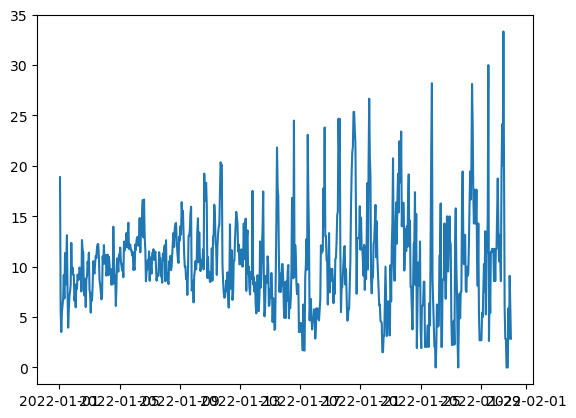

In [9]:
plt.plot((propor['Marine']/propor['Colloidal'])*100)

(0.0, 100.0)

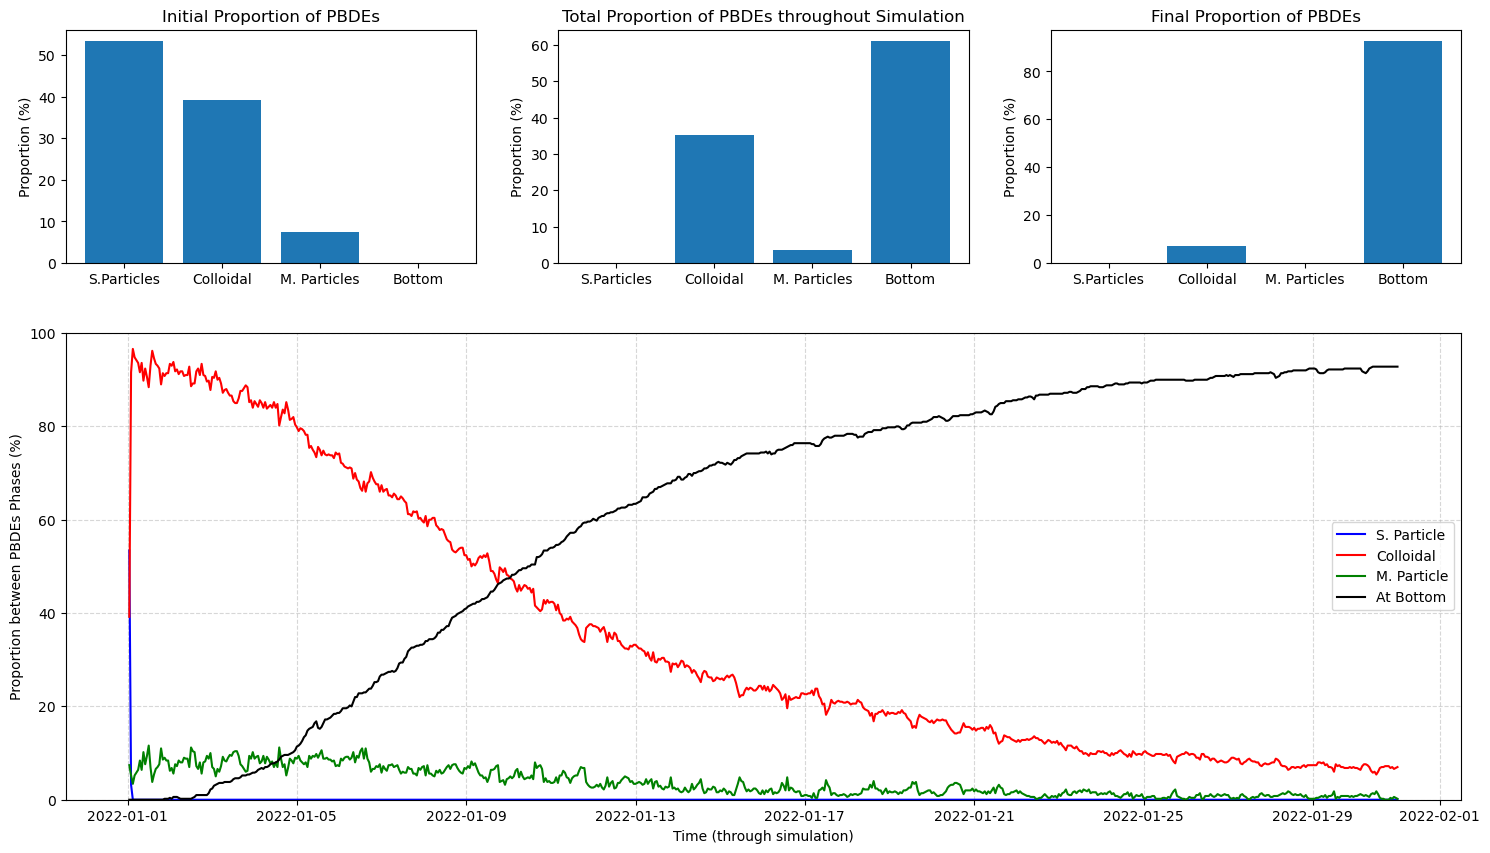

In [10]:
fig = plt.figure(figsize = (18,10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.bar(cat, aa_in)
ax1.set_title('Initial Proportion of PBDEs')
ax1.set_ylabel('Proportion (%)')
ax2.bar(cat, aa)
ax2.set_title('Total Proportion of PBDEs throughout Simulation')
ax2.set_ylabel('Proportion (%)')
ax3.bar(cat, aa_fin)
ax3.set_title('Final Proportion of PBDEs')
ax3.set_ylabel('Proportion (%)')
#
ax4 = fig.add_subplot(gs[1, :])

ax4.plot(propor['Sewage'], 'b', label = 'S. Particle')
ax4.plot(propor['Colloidal'], 'r', label = 'Colloidal')
ax4.plot(propor['Marine'], 'g', label = 'M. Particle')
ax4.plot(propor['Bottom'], 'k', label = 'At Bottom')
ax4.set_ylabel('Proportion between PBDEs Phases (%)')
ax4.set_xlabel('Time (through simulation)')
ax4.legend()
ax4.grid(linestyle = '--', alpha = 0.5)
#ax.set_title('Particle status proportion between ' + str(date_jan_start) + ' and ' + str(date_jan_end))
ax4.set_ylim(0,100)

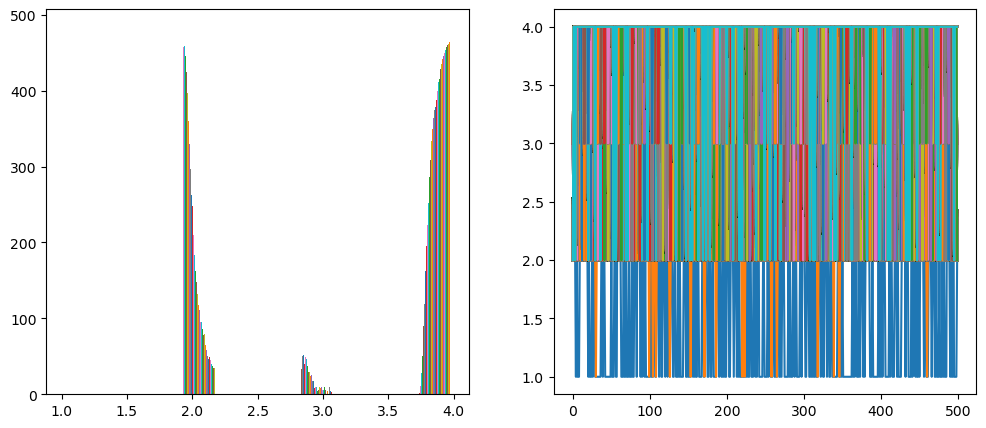

In [11]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].hist(data.status)
ax[1].plot(data.status)

Text(0, 0.5, 'Latitude')

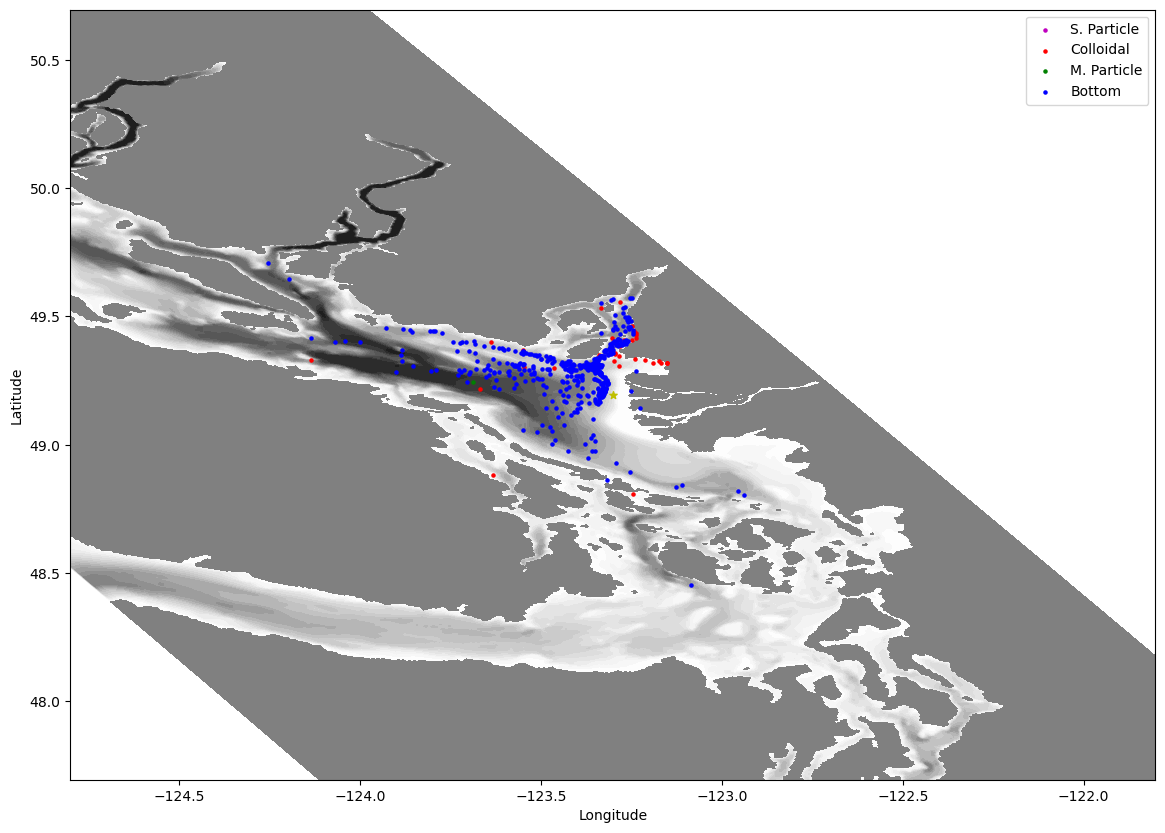

In [12]:
fig,axs=plt.subplots(figsize=(14,10))
#
tt = -1
#
# Make map
blevels = list(np.arange(0,500,20))
im=axs.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 1),data.lat[:,tt].where(data.status[:,tt] == 1),zorder=3,c='m',s=5, label = 'S. Particle')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 2),data.lat[:,tt].where(data.status[:,tt] == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 3),data.lat[:,tt].where(data.status[:,tt] == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 4),data.lat[:,tt].where(data.status[:,tt] == 4),zorder=3,c='b',s=5, label = 'Bottom')
#
axs.legend()
axs.scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs.set_ylim([clat[0]-1.5,clat[0]+1.5])
axs.set_xlim([clon[0]-1.5,clon[0]+1.5])
#axs[0].set_title(f'Final Particles position during '+ str(date_jan_end))
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')

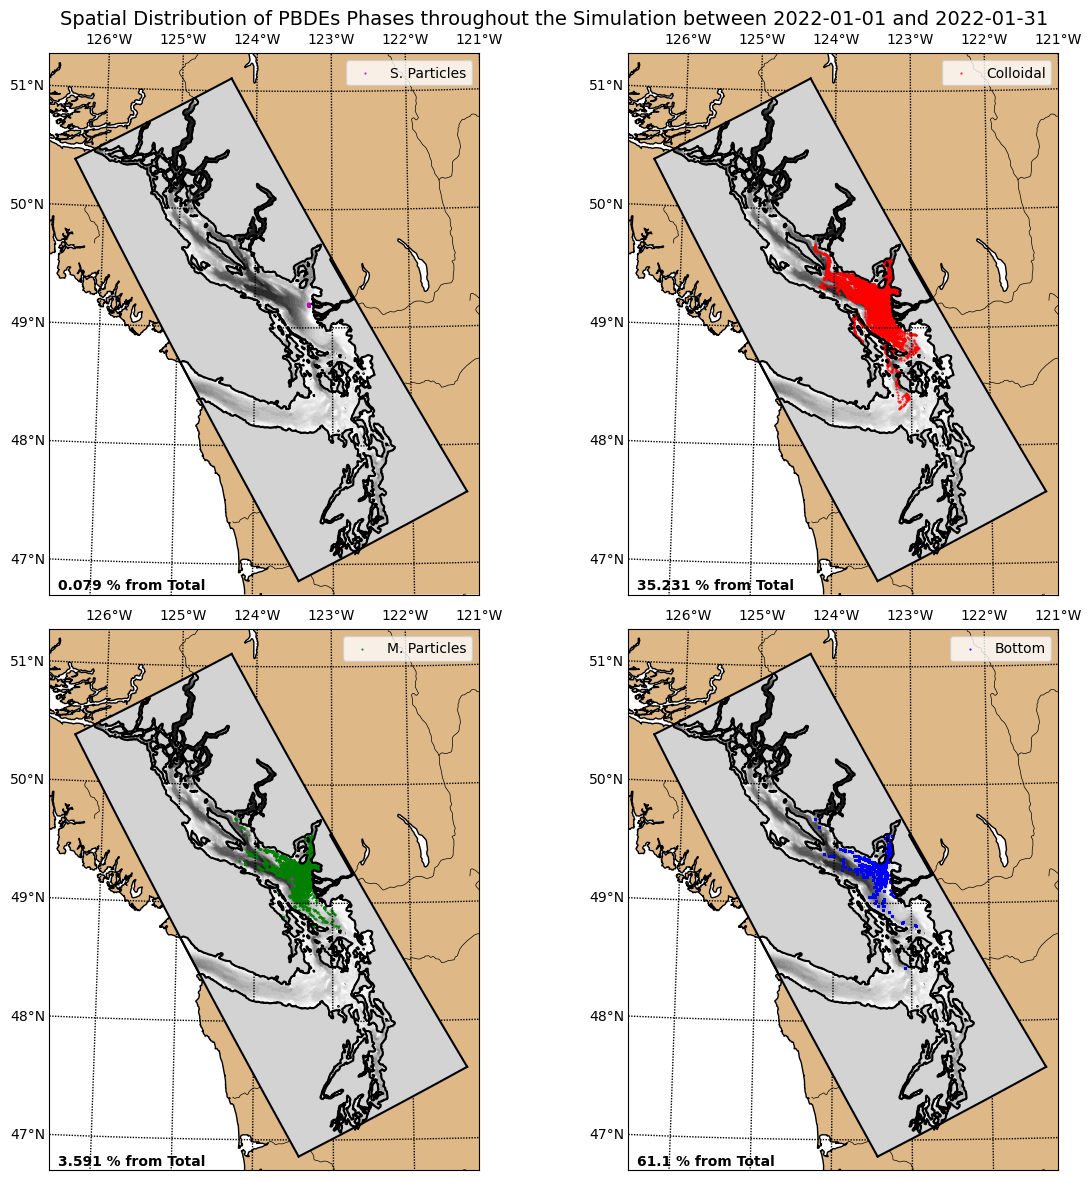

In [13]:
fig, ax = plt.subplots(2,2,figsize = (12,12))
mapitas.plot_nice_map(data = data, figure = fig, plot_axis = ax[0,0], data_lon=data.lon.where(data.status == 1), data_lat=data.lat.where(data.status == 1), size = 1, color_particle = 'm', label_particle='S. Particles', percentage = aa[0])
mapitas.plot_nice_map(data = data,figure = fig, plot_axis = ax[0,1], data_lon=data.lon.where(data.status == 2), data_lat=data.lat.where(data.status == 2), size = 1, color_particle = 'r', label_particle='Colloidal', percentage = aa[1])
mapitas.plot_nice_map(data = data,figure = fig, plot_axis = ax[1,0], data_lon=data.lon.where(data.status == 3), data_lat=data.lat.where(data.status == 3), size = 1, color_particle = 'g', label_particle='M. Particles', percentage = aa[2])
mapitas.plot_nice_map(data = data,figure = fig, plot_axis = ax[1,1], data_lon=data.lon.where(data.status == 4), data_lat=data.lat.where(data.status == 4), size = 1, color_particle = 'b', label_particle='Bottom', percentage = aa[3])
#
plt.tight_layout()

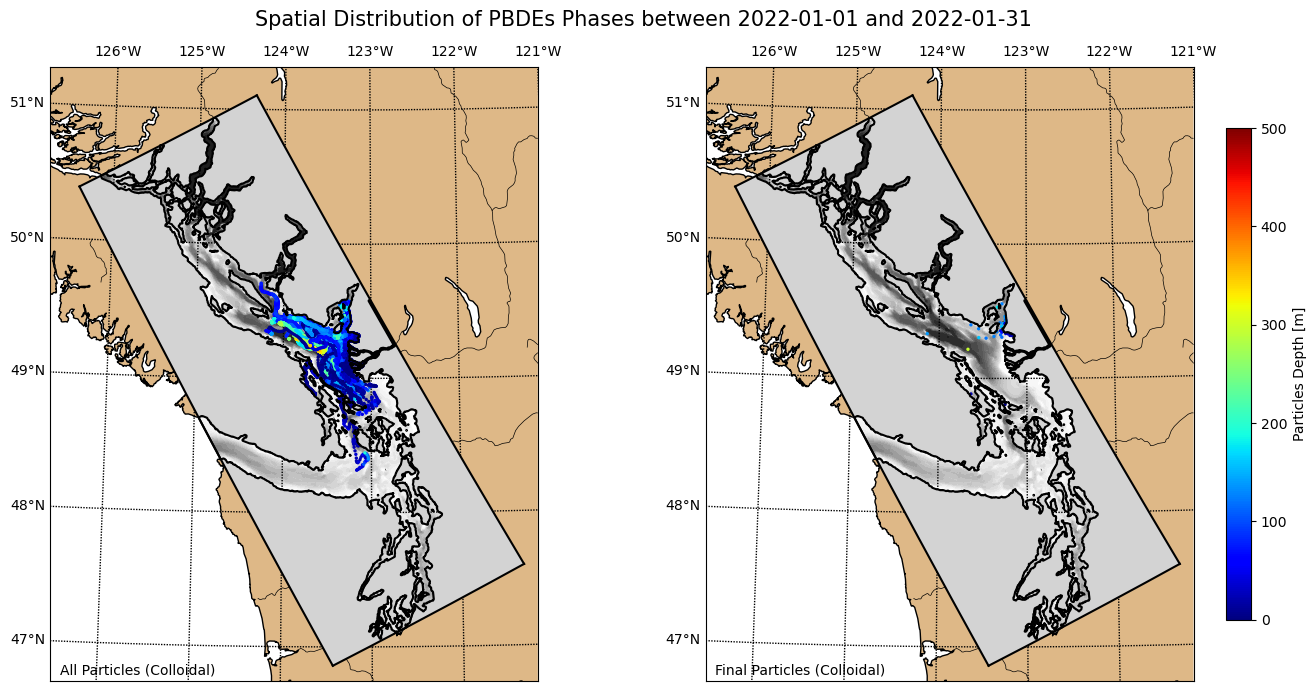

In [14]:
mapitas.plot_distribution(data, depth, 2)

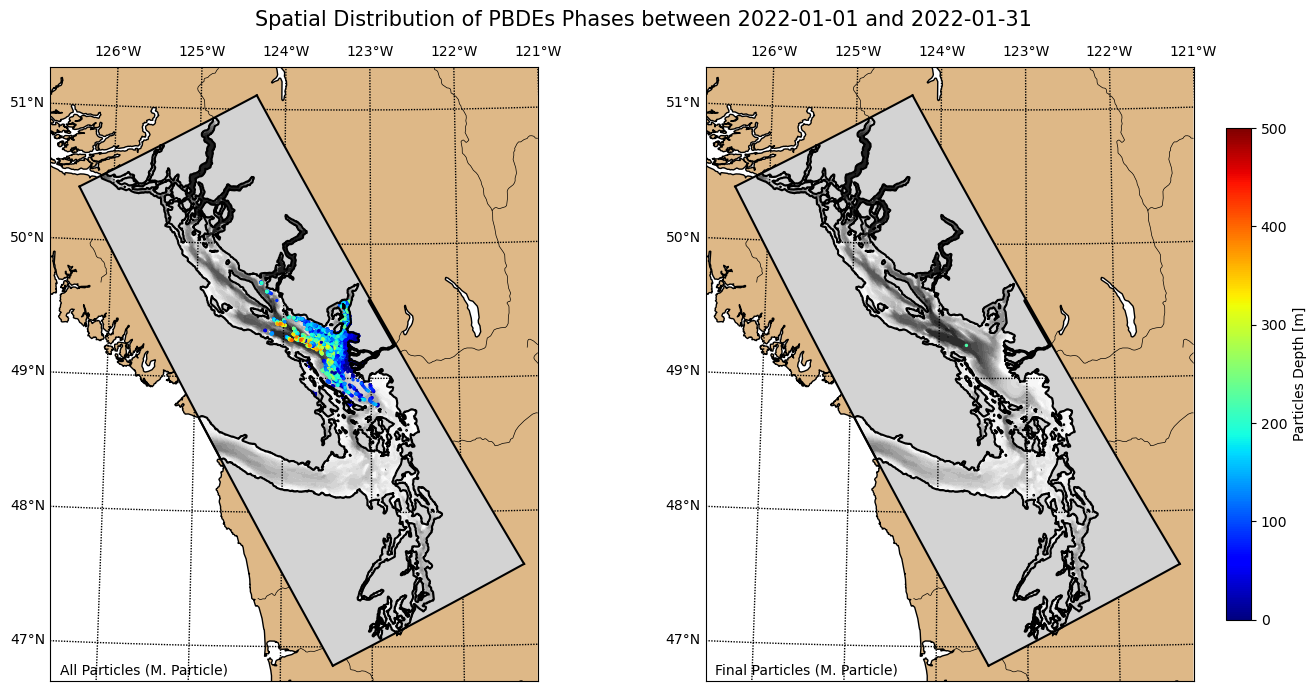

In [15]:
mapitas.plot_distribution(data, depth, 3)

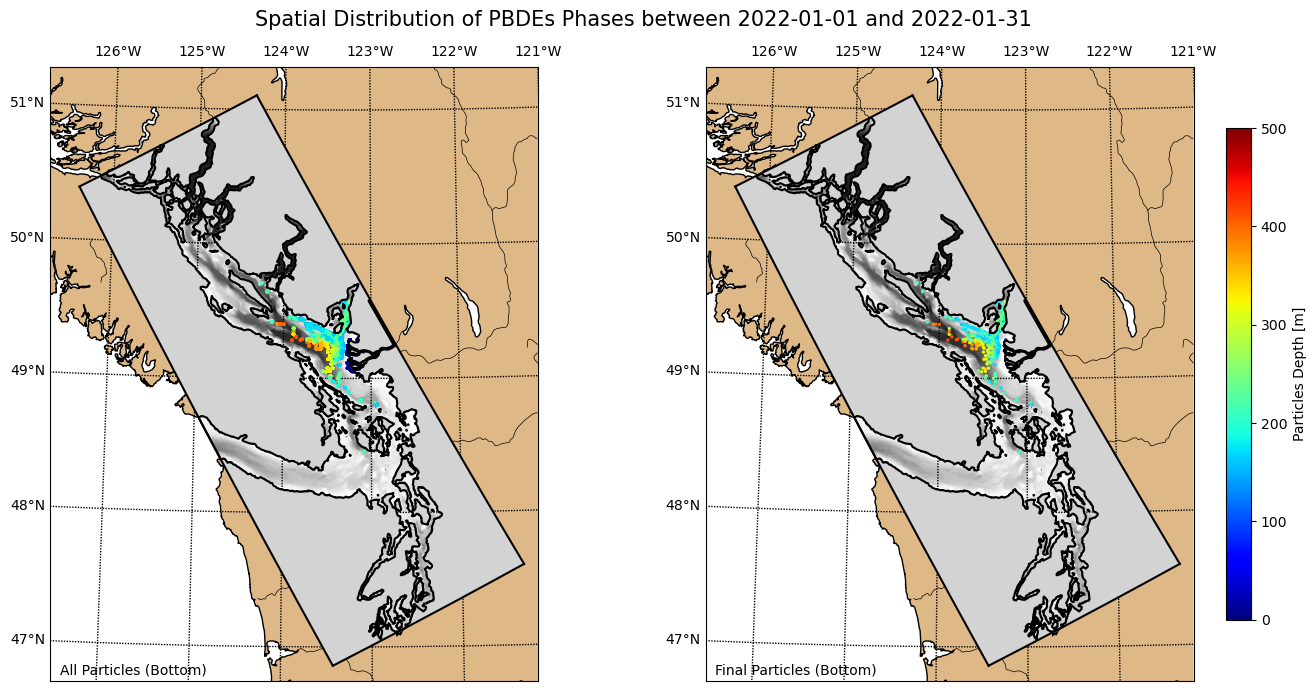

In [16]:
mapitas.plot_distribution(data, depth, 4)

**Lets try to build up an animation for particles evolution through time**

In [17]:
from matplotlib.colors import ListedColormap, BoundaryNorm
# create a colorbar
colors = ['magenta', 'red', 'green', 'blue']
cmap = ListedColormap(colors)
#
bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(bounds, cmap.N)

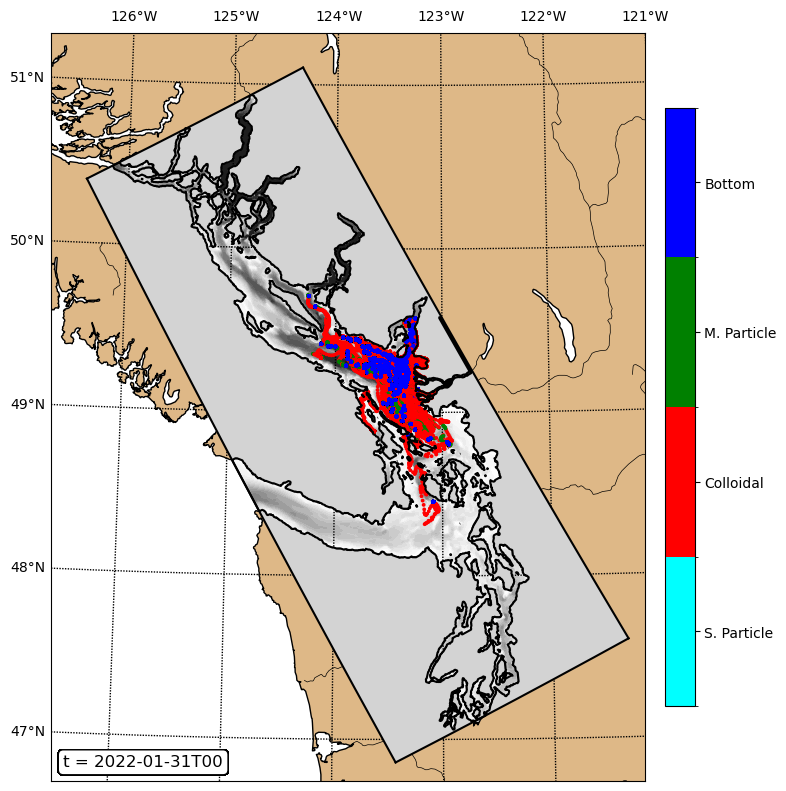

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.transforms import Affine2D

# Define discrete colormap and normalization
colors = ['cyan', 'red', 'green', 'blue']
cmap = ListedColormap(colors)
bounds = [1, 2, 3, 4, 5] 
norm = BoundaryNorm(bounds, cmap.N)
#
#
#
# Create map
fig, plot_axis = plt.subplots(figsize=(10, 8)) 
#
clat = 49.195045
clon = -123.301956
rotation_angle = 10  # Rotation angle in degrees
#
#
w_map = [-126.5, -121, 46.7, 51.3]
# Define a rotated pole projection with a shifted pole to create the rotation effect
m = Basemap(projection='lcc', resolution='h',
            lon_0=clon, lat_0=clat,
            llcrnrlon=w_map[0], urcrnrlon=w_map[1],
            llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=plot_axis)
#
lons = np.arange(*np.floor([w_map[0], w_map[1] + 1]))
lats = np.arange(*np.floor([w_map[2], w_map[3] + 1]))
#
labels = [[0, 0, 1, 0], [1, 0, 0, 0]]
#
m.drawcoastlines(zorder=1)
m.fillcontinents(color='Burlywood', zorder=0)
m.drawmeridians(lons, color='k',labels = labels[0], yoffset=None, zorder=2)
m.drawparallels(lats, color='k',labels = labels[1], xoffset=None, zorder=2)
m.drawrivers(zorder=2)
#
x, y = m(coords.nav_lon, coords.nav_lat)
#
blevels = list(np.arange(0,500,20))
#
im = plot_axis.contourf(x, y, mask.totaldepth[:,:], zorder=1,cmap = 'Greys',levels=blevels, extend='both')
plot_axis.contourf(x, y, mask.totaldepth[:,:], [-0.01, 0.01], colors='lightgray', zorder=3)
plot_axis.contour( x, y, mask.totaldepth[:,:], [0], colors='Black', zorder=4)
#
plot_axis.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
plot_axis.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
plot_axis.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
plot_axis.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
#
tt = 0  # Time index
blevels = list(np.arange(0, 500, 20))
#
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=plot_axis, orientation='vertical', pad=0.02, shrink=0.8,
    ticks=[1.5, 2.5, 3.5, 4.5] 
)
cbar.ax.set_yticklabels(['S. Particle', 'Colloidal', 'M. Particle', 'Bottom'])
#
plt.tight_layout()
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles', artist='Vicente',
                comment='Particles movement (Year 2022)')
writer = FFMpegWriter(fps=30, metadata=metadata)

with writer.saving(fig, path['anim']+"/PBDEs_phases_animation_V2.mp4", 100):
    for tm in range(len(data.obs)):
        xx, yy = m(data.lon[:, tm],data.lat[:, tm])
        sc = plot_axis.scatter(xx, yy ,zorder=3, c=data.status[:, tm], s=3,cmap=cmap, norm=norm)
        plot_axis.text(0.155, 0.025, 't = ' + str(data.time[0,:].values[tm])[:13], transform=plot_axis.transAxes, fontsize=12,
        ha="center", va="center", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))  
        writer.grab_frame()



**Now, lets try to build up an animation for particles evolution through time showing their depth**

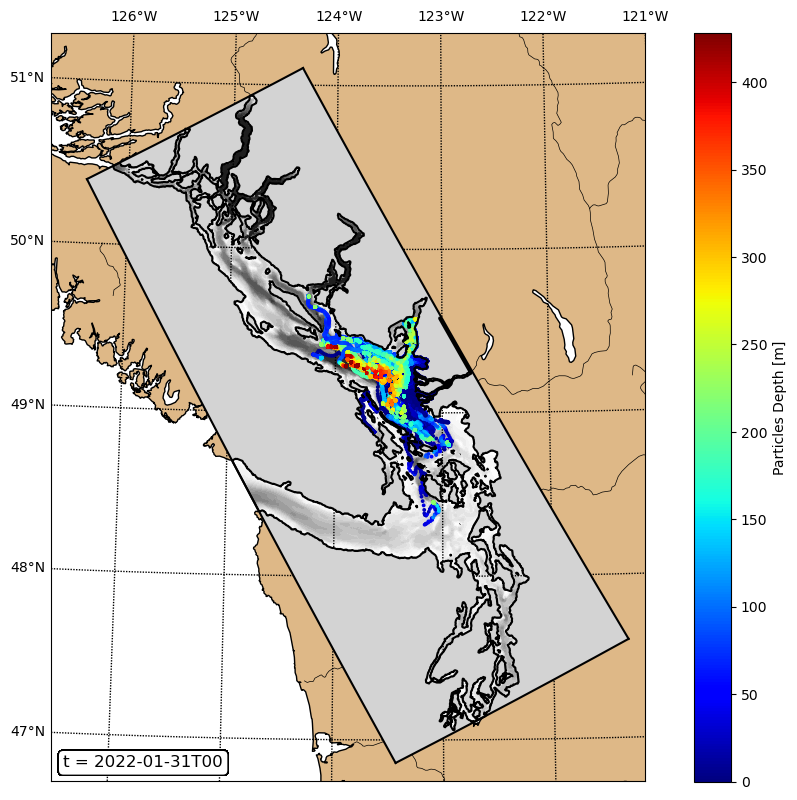

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.transforms import Affine2D
#
# Create map
fig, plot_axis = plt.subplots(figsize=(10, 8)) 
#
clat = 49.195045
clon = -123.301956
rotation_angle = 10  # Rotation angle in degrees
#
#
w_map = [-126.5, -121, 46.7, 51.3]
# Define a rotated pole projection with a shifted pole to create the rotation effect
m = Basemap(projection='lcc', resolution='h',
            lon_0=clon, lat_0=clat,
            llcrnrlon=w_map[0], urcrnrlon=w_map[1],
            llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=plot_axis)
#
lons = np.arange(*np.floor([w_map[0], w_map[1] + 1]))
lats = np.arange(*np.floor([w_map[2], w_map[3] + 1]))
#
labels = [[0, 0, 1, 0], [1, 0, 0, 0]]
#
m.drawcoastlines(zorder=1)
m.fillcontinents(color='Burlywood', zorder=0)
m.drawmeridians(lons, color='k',labels = labels[0], yoffset=None, zorder=2)
m.drawparallels(lats, color='k',labels = labels[1], xoffset=None, zorder=2)
m.drawrivers(zorder=2)
#
x, y = m(coords.nav_lon, coords.nav_lat)
#
blevels = list(np.arange(0,500,20))
#
im = plot_axis.contourf(x, y, mask.totaldepth[:,:], zorder=1,cmap = 'Greys',levels=blevels, extend='both')
plot_axis.contourf(x, y, mask.totaldepth[:,:], [-0.01, 0.01], colors='lightgray', zorder=3)
plot_axis.contour( x, y, mask.totaldepth[:,:], [0], colors='Black', zorder=4)
#
plot_axis.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
plot_axis.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
plot_axis.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
plot_axis.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
#
tt = 0  # Time index
blevels = list(np.arange(0, 500, 20))
#
plt.tight_layout()
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles', artist='Vicente',
                comment='Particles movement (Year 2022)')
writer = FFMpegWriter(fps=30, metadata=metadata)

with writer.saving(fig, path['anim']+"/PBDEs_depth_animation_V2.mp4", 100):
    for tm in range(len(data.obs)):
        xx, yy = m(data.lon[:, tm],data.lat[:, tm])
        sc = plot_axis.scatter(xx, yy ,zorder=3, c=depth[:, tm], s=3,cmap='jet')
        if tm == 0:  # Adding colorbar only once
            sc.set_clim(0,mask.totaldepth.max())
            cb1 = fig.colorbar(sc, ax=plot_axis)
            cb1.set_label('Particles Depth [m]')
        plot_axis.text(0.155, 0.025, 't = ' + str(data.time[0,:].values[tm])[:13], transform=plot_axis.transAxes, fontsize=12,
        ha="center", va="center", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
        writer.grab_frame()

**Next step: Separate by regions and get info**